# Laboratorio 1
**Andrés Neira - 202123126**

**Esteban Castelblanco**

## 1. Carga de datos

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Número máximo de filas a mostar

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
db_location = './datos_entrenamiento_laboratorio1(train_data).csv'
df_fut = pd.read_csv(db_location, sep=',', encoding = "utf-8")

In [3]:
df_fut.shape

(57934, 50)

In [4]:
display(df_fut.sample(5))

,Jugador,Nacionalidad,Posicion,Edad,Dia_partido,Goles,Tiros Totales,xG,npxG,xAG,xAG.1,Acciones_que_crean_tiros,...,Veces_que_fue_barrido_regate,Acarreos_ultimo_tercio,Malos_controles,Perdida_balon,Pases_recibidos,Pases_progresivos_recibidos,Faltas_cometidas,Centros,Duelos_aereos_ganados,%_de_duelos_aereos_ganados,market_value,contract_date
10627,Diego Gomez,py PAR,DM,22-030,"Saturday April 26, 2025",0,0,0.0,0.0,0.0,0.0,2,...,0,0,0,0,3,1,0,0,0,NaN,€14.00m,-
20204,Jaime Mata,es ESP,FW,36-121,"Saturday February 22, 2025",0,0,0.0,0.0,0.0,0.0,0,...,0,0,1,0,8,0,1,0,3,75.0,NaN,NaN
5923,Liam Delap,eng ENG,FW,21-326,"Monday December 30, 2024",1,4,1.0,0.2,0.1,0.1,4,...,1,2,6,3,17,3,1,0,3,75.0,€40.00m,30.06.2031
353,Erling Haaland,no NOR,FW,24-034,"Saturday August 24, 2024",3,6,1.8,1.0,0.0,0.0,1,...,1,0,0,0,15,3,0,0,1,100.0,€180.00m,30.06.2034
14949,Luis Perez,es ESP,RB,29-244,"Saturday October 5, 2024",0,0,0.0,0.0,0.4,0.4,6,...,0,3,3,0,23,8,1,8,0,0.0,NaN,NaN


# 2. Entendimiento de datos

Haciendo uso de ydata_profiling, se pudo revisar inconsistencias con los datos y colinealidad.

In [5]:
#El reporte automático se demora un poco en realizarse
#from ydata_profiling import ProfileReport
#profiling = ProfileReport(df_fut, title='Reporte', explorative=True)
#profiling

Las variables elegidas para la construcción del modelo son las siguientes: 

### Target
* market_value → variable objetivo que representa el precio de mercado estimado de un jugador.

### Parámetros
* Edad → jugadores más jóvenes suelen tener mayor valor de mercado que los veteranos.

* Goles → reflejan la capacidad ofensiva y están fuertemente ligados al precio de atacantes.

* xG → métrica avanzada que mide la calidad de los tiros, elegida sobre otras (npXG, etc.) por ser más representativa del rendimiento ofensivo.

* xA → mide las asistencias esperadas, preferida frente a otras estadísticas similares porque captura mejor la generación de oportunidades.

* Regates_exitosos → se usó el número absoluto en lugar del porcentaje, ya que para defensas y mediocampistas es más informativo el total.

* Pases_completados → correlaciona con otros tipos de pases (largos, cortos, centros), pero se eligió por ser la métrica más general y significativa.

* Valla_no_vencida → importante en jugadores defensivos, especialmente porteros.

* Errores_defnsivos_ocasion_tiro → errores graves que afectan negativamente el valor.

* Malos_controles → errores técnicos que disminuyen la valoración del jugador.

* Perdida_balon → refleja la seguridad en la posesión, a mayor número, menor valor.

* Faltas_cometidas → indicador de disciplina e inconsistencia, un exceso reduce el valor percibido.

* %_de_duelos_aereos_ganados → mide efectividad en el juego aéreo, relevante para defensas y delanteros.

* contract_date → días restantes de contrato, ya que contratos largos aumentan el valor de mercado

* Posicion → Algunas estadísticas, como los goles, valen más para jugadores ofensivos que para defensivos, que tienen otras métricas como porterías imbatidas, por esto es importante tener en cuenta la posición.

## Revisión de colinealidad

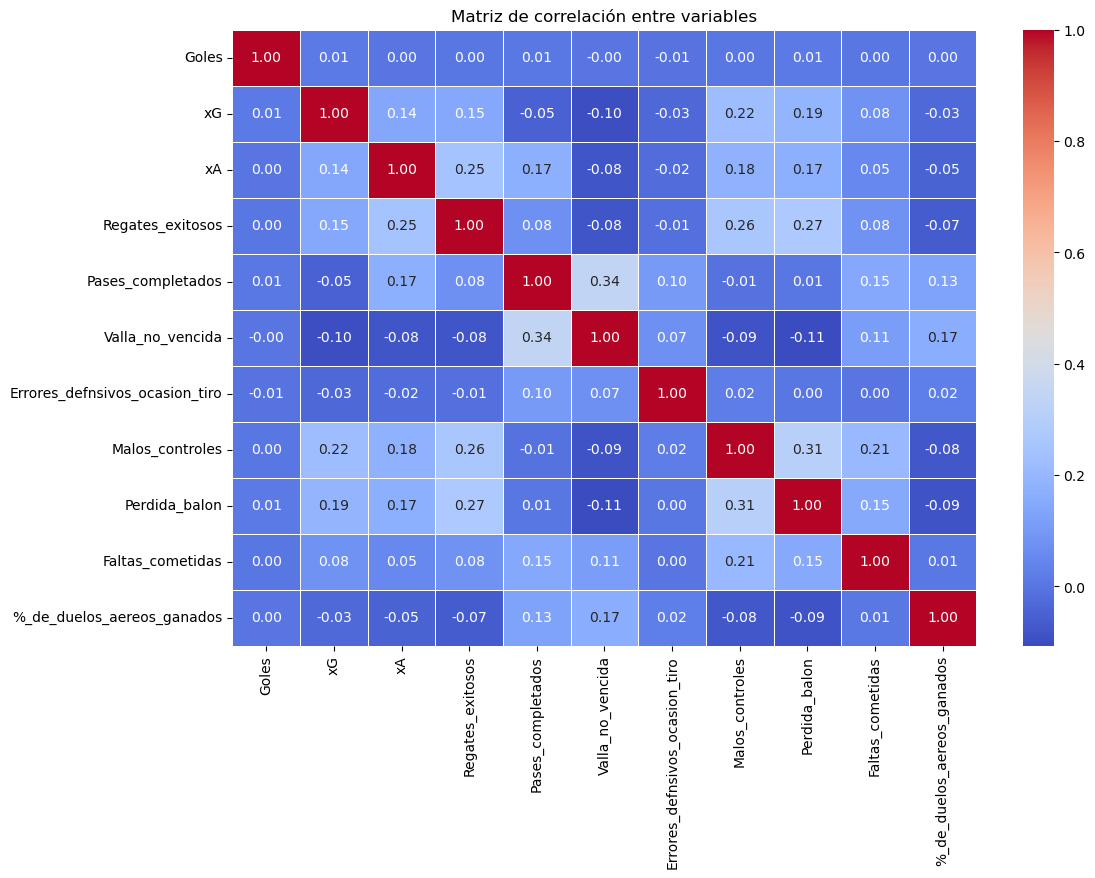

In [6]:
import seaborn as sns
variables = [
    "Goles",
    "xG",
    "xA",
    "Regates_exitosos",
    "Pases_completados",
    "Valla_no_vencida",
    "Errores_defnsivos_ocasion_tiro",
    "Malos_controles",
    "Perdida_balon",
    "Faltas_cometidas",
    "%_de_duelos_aereos_ganados"
]
corr = df_fut[variables].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables")
plt.show()

Podemos ver que la mayoría de los parámetros númericos tienen una baja-media colinealidad entre ellos, por lo que son aceptables como un primer acercamiento para contruir el modelo.

## Revisión de errores e inconsistencias en los datos

In [7]:
df_fut[variables].dtypes

Goles                               int64
xG                                float64
xA                                float64
Regates_exitosos                    int64
Pases_completados                   int64
Valla_no_vencida                    int64
Errores_defnsivos_ocasion_tiro      int64
Malos_controles                     int64
Perdida_balon                       int64
Faltas_cometidas                    int64
%_de_duelos_aereos_ganados        float64
dtype: object

In [8]:
no_numericas = ['market_value', 'Edad', 'contract_date', 'Posicion']
df_fut[no_numericas].dtypes

market_value     object
Edad             object
contract_date    object
Posicion         object
dtype: object

Aquí podemos observar que tanto la variable objetivo como la edad, la posición y el contract_date no estan puestos en formato númerico, por lo que tocará ajustarlo más adelante.

In [9]:
df_fut[variables].describe()

,Goles,xG,xA,Regates_exitosos,Pases_completados,Valla_no_vencida,Errores_defnsivos_ocasion_tiro,Malos_controles,Perdida_balon,Faltas_cometidas,%_de_duelos_aereos_ganados
count,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,57934.000000,36977.000000
mean,0.513015,0.088635,0.055056,0.487451,25.745624,1.502727,0.041513,0.950133,0.574033,0.781337,48.814187
std,16.440600,0.209810,0.122355,0.897683,20.703206,2.169317,0.207865,1.221368,0.931852,1.005105,39.560765
min,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,21.000000,1.000000,0.000000,1.000000,0.000000,0.000000,50.000000
75%,0.000000,0.100000,0.100000,1.000000,37.000000,2.000000,0.000000,1.000000,1.000000,1.000000,100.000000
max,995.000000,2.900000,1.400000,15.000000,163.000000,21.000000,3.000000,10.000000,8.000000,9.000000,100.000000


In [10]:
df_fut.isna().sum()

Jugador                               0
Nacionalidad                         32
Posicion                              0
Edad                                 48
Dia_partido                           0
Goles                                 0
Tiros Totales                         0
xG                                    0
npxG                                  0
xAG                                   0
xAG.1                                 0
Acciones_que_crean_tiros              0
Pases_intentados                      0
Pases_intentados.1                    0
Pases_intentados.2                    0
Pases_progresivos                     0
Pases_progresivos.1                   0
Regates_exitosos                      0
Regates_exitosos.1                    0
Pases_medios_completados              0
Pases_largos_completados              0
xAG.2                                 0
xAG.3                                 0
xA                                    0
Pases_en_ultimo_tercio                0


Ahora, revisando nulidad, vemos que, respecto a las variables de interes, el market_value, el contract_date y el % de duelos aereos ganados tienen un gran número de valores nulos o ausencias, por lo que se deberá arreglar más tarde. Por su parte, edad tiene también algunos nulos en sus datos. También podemos ver columnas repetidas, como por ejemplo regates exitosos y pases completados.

# 3. Perfilamiento y limpieza de datos

## 3.1 Completitud de los datos

Ahora, revisando la integridad y la coherencía de los datos, vemos que hay problemas con los goles, ya que se tienen valores negativos, y además se cuenta con un máximo altisimo de 995 goles en un partido. 

Revisamos el porcentaje de ceros de las variables que nos interesan.

In [11]:
100*((df_fut.isna().sum())/len(df_fut)).to_frame()

,0
Jugador,0.000000
Nacionalidad,0.055235
Posicion,0.000000
Edad,0.082853
Dia_partido,0.000000
Goles,0.000000
Tiros Totales,0.000000
xG,0.000000
npxG,0.000000
xAG,0.000000


### Arreglo de valores nulos de market_value


Para los valores nulos de market_value, la decisión de negocio fue simplemente borrar las filas que tengan un valor de market_value nulo, ya que al tratarse del target, se considera que es demasiado significativo para hacer imputación de valores con algún metódo estadístico.

In [12]:
df_fut = df_fut.dropna(subset='market_value')

In [13]:
df_fut['market_value'].value_counts()['error']

np.int64(49)

In [14]:
df_fut['market_value'].value_counts()['-']

np.int64(151)

Vemos que hay valores de 'error' y '-' en market_value, por lo que es necesario quitarlos

In [15]:
df_fut = df_fut[df_fut['market_value'] != 'error']

df_fut = df_fut[df_fut['market_value'] != '-']

### Arreglo de valores nulos de contract_date


In [16]:
df_fut['contract_date'].isna().sum()

np.int64(11)

Vemos que aún existen valores nulos para contract_date, pero al ser muy pocos se decidió eliminarlos de los datos

In [17]:
df_fut = df_fut.dropna(subset='contract_date')

Vemos que algunos valores de contract_date son '-', por lo que es necesario quitarlos de los datos

In [18]:
df_fut['contract_date'].value_counts()['-']

np.int64(967)

In [19]:
df_fut = df_fut[df_fut['contract_date'] != '-']

### Arreglo de valores nulos de %de_duelos_aereos_exitosos

In [20]:
100* (df_fut['%_de_duelos_aereos_ganados'].isna().sum())/len(df_fut)

np.float64(35.990150927910264)

Podemos ver que el porcentaje de nulos de esta categoría es de casi el 40%, por lo que borraron los datos no es una opción muy viable. Es por esto que se decidió hacer una imputación por algún valor estadístico.

In [21]:
df_fut['%_de_duelos_aereos_ganados'].describe()

count    28076.000000
mean        49.305588
std         39.402193
min          0.000000
25%          0.000000
50%         50.000000
75%        100.000000
max        100.000000
Name: %_de_duelos_aereos_ganados, dtype: float64

Creemos que una buena decisión sería reemplazar los valores nulos por la media, ya que la medía esta situada casi en el 50% que además tiene percentil 50%, por lo que es bastante equitativo.

In [22]:
df_fut['%_de_duelos_aereos_ganados'] = df_fut['%_de_duelos_aereos_ganados'].fillna(df_fut['%_de_duelos_aereos_ganados'].mean())

### Arreglo de valores nulos de edad

In [23]:
df_fut['Edad'].mode()

0    24-231
Name: Edad, dtype: object

In [24]:
df_fut['Edad'].isna().sum()

np.int64(18)

Podemos ver que solo 18 datos de edad tienen valores nulos, por lo que estos pueden ser fácilmente reemplazados por una media estadística. En este caso, se tomará la moda o el valor más repetido.

In [25]:
df_fut['Edad'] = df_fut['Edad'].fillna(df_fut['Edad'].mode()[0])

## 3.2 Arreglo de formatos

### Arreglo de formato de market_value

Ahora es necesario convertir los valores de market_value a números para que puedan ser trabajados por el modelo, por lo que creamos una nueva columna para estos valores

In [26]:
def convertir_precio(valor):
    valor = str(valor).lower().replace("$", "").replace("€", "").replace("£", "")
    if valor.endswith("m"):
        return float(valor.replace("m", "")) * 1_000_000
    elif valor.endswith("k"):
        return float(valor.replace("k", "")) * 1_000
    elif valor in ["free", "0"]:
        return 0
    else:
        return float(valor)

df_fut['new_market_value'] = df_fut['market_value'].apply(convertir_precio)

### Arreglo de formato de contract_date

Ahora vamos a crear una nueva columna númerica que represente el contract_date en forma númerica. Como decisión de negocio, se propuso que exista una nueva columna llamada 'days_left' que represente el total de días restantes del contrato de un jugador, teniendo en cuenta la fecha de hoy.

In [27]:
df_fut['contract_date'] = pd.to_datetime(df_fut['contract_date'], format="%d.%m.%Y")
df_fut["days_left"] = (df_fut["contract_date"] - pd.Timestamp.today()).dt.days

In [28]:
df_fut["days_left"].describe()

count    43862.000000
mean       945.506429
std        512.324397
min        302.000000
25%        667.000000
50%       1033.000000
75%       1398.000000
max       3589.000000
Name: days_left, dtype: float64

Vemos que no hay fechas negativas ni valores exagerados, entonces no hay problemas subsecuentes.

### Arreglo de formato de edad

In [29]:
df_fut['Edad'].value_counts()

Edad
24-231    46
23-074    27
23-137    26
22-243    26
24-182    25
          ..
34-330     1
35-315     1
19-312     1
36-159     1
36-216     1
Name: count, Length: 6563, dtype: int64

In [30]:
def transformar_edad(edad):
    edad = str(edad)
    partes_edad = edad.split('-')
    return float(partes_edad[0]) + (float(partes_edad[1])/365)

In [31]:
df_fut['Edad'] = df_fut['Edad'].apply(transformar_edad)

In [32]:
df_fut['Edad'].describe()

count    43862.000000
mean        26.155851
std          4.140171
min         16.561644
25%         23.008219
50%         25.708219
75%         28.923288
max         41.578082
Name: Edad, dtype: float64

### Arreglo de formato de posicion

El problema con la posición en este modelado, es que el valor de mercado de diferentes posiciones se mide con diferentes párametros. A un ataquante se le juzgara más por goles, mientras que a un defensor o un arquero se le valorará más por sus porterías imbatidas. Una opción que fue considerada es construir varios modelos para diferentes posiciones. Al final, se decidió hacer un One-hot-encoding con 4 columnas: arquero, defensa, mediocampo y ofensivo. De esta forma, dependiendo de las posiciones que juegue el jugador, se asignará un 1 en la columna correspondiente. Esto se hace con el objetivo de que el modelo aprenda a identificar las posiciones para las cuales algunos párametros valen más que otros.

In [33]:
df_fut["arquero"] = 0
df_fut["defensa"] = 0
df_fut["mediocampo"] = 0
df_fut["ofensivo"] = 0

df_fut.loc[df_fut["Posicion"].str.contains("GK", na=False), "arquero"] = 1

df_fut.loc[df_fut["Posicion"].str.contains("DF|CB|LCB|RCB|LB|RB|LWB|RWB|WB|SW", na=False), "defensa"] = 1

df_fut.loc[df_fut["Posicion"].str.contains("MF|CM|LCM|RCM|DM|CDM|CAM|AM|LM|RM", na=False), "mediocampo"] = 1

df_fut.loc[df_fut["Posicion"].str.contains("FW|ST|CF|SS|LW|RW|WF", na=False), "ofensivo"] = 1

## 3.3 Unicidad de los datos y consistencia

Ahora podemos ver como existen más de 7000 filas duplicadas, por lo que se eliminarán las duplicadas y se conservará la primera.

### Valores negativos

Podemos ver que el dato Goles cuenta con al menos un valor negativo en una de las filas. Para arreglar esto, solo sacaremos el valor absoluto de la columna.

In [34]:
df_fut['Goles'].min()

-5

In [35]:
df_fut["Goles"] = df_fut["Goles"].abs()

### Valores sesgados

Si analizamos los valores estadístico del parámetro Goles, veremos que esta supremamente sesgado hacia la derecha, por lo que se tiene que escalar los goles, además de que existen valores completamente irreales como 995 goles en un partido. Para escalar los goles a valores mas reales y balanceados, se aplicará una función logaritmica para bajar los valores grandes, mientras que los pequeños no se ven tan afectados.

In [36]:
df_fut['Goles'].describe()

count    43862.000000
mean         0.363116
std         13.487592
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        995.000000
Name: Goles, dtype: float64

In [37]:
df_fut['Goles'].var()

181.9151330176917

In [38]:
df_fut["Goles_escalados"] = np.log1p(df_fut["Goles"])

También podemos observar que el market_value tiene un comportamiento similar, con valores extremos absurdamente grandes (del orden de 10^9), con varianza y skeweness abruptos. Para este caso, la estrategia estadistica de aplicar una función logaritmica no sería buena idea, porque perderíamos el valor de los datos de los precios. Por lo tanto, se decidió cortar de los datos en el percentil 99%, es decir, se cortarán el 5% de datos más altos. El 99% se decidió ya que se detectó que solo pocos valores, probablemente el 1% o menos, alcanzan el orden de 10^9, mientras que el percentil 99% se encuentra por debajo del orden de 10^8, que es un valor posible dentro de los precios de futbolistas actualmente.

In [39]:
df_fut['new_market_value'].describe()

count    4.386200e+04
mean     2.631898e+07
std      2.984307e+08
min      5.000000e+04
25%      3.600000e+06
50%      1.000000e+07
75%      2.300000e+07
max      9.999990e+09
Name: new_market_value, dtype: float64

In [40]:
df_fut['new_market_value'].var()

8.906090078326411e+16

In [41]:
df_fut['new_market_value'].skew()

np.float64(33.19488304673991)

In [42]:
percentil99 = df_fut["new_market_value"].quantile(0.95)

In [43]:
df_fut = df_fut[df_fut['new_market_value'] <= percentil99]

### Duplicados totales

In [44]:
df_fut.duplicated().sum()

np.int64(7200)

In [45]:
df_fut = df_fut.drop_duplicates(keep='first')

### Duplicados parciales

La columna cuyos duplicados nos importan para la integridad de los datos es la columna de los jugadores, ya que puede haber 2 mismos jugadores con diferentes valores de mercado y diferentes estadísticas. 

In [46]:
df_fut['Jugador'].value_counts()

Jugador
Ederson                  126
Mateus Fernandes         108
Lucas Torro              105
Alessandro Bianco        105
Alejandro Balde           96
                        ... 
Alessandro Florenzi        1
Saba Sazonov               1
Adrian Nino                1
Aaron Ciammaglichella      1
Melvin Zinga               1
Name: count, Length: 1458, dtype: int64

También podemos ver una inconsistencia, en el sentido de que hay jugadores que tienen dos o más filas repetidas por jugador y día, es decir, un mismo jugador con un mismo partido, pero con estadísticas diferentes.

In [47]:
df_fut[df_fut.duplicated(subset=["Jugador", 'Dia_partido'], keep=False)]

,Jugador,Nacionalidad,Posicion,Edad,Dia_partido,Goles,Tiros Totales,xG,npxG,xAG,xAG.1,Acciones_que_crean_tiros,...,Centros,Duelos_aereos_ganados,%_de_duelos_aereos_ganados,market_value,contract_date,new_market_value,days_left,arquero,defensa,mediocampo,ofensivo,Goles_escalados
17,Rodrigo Muniz,br BRA,FW,23.284932,"Friday August 16, 2024",0,2,0.1,0.1,0.1,0.1,2,...,0,4,40.000000,€1.00m,2028-06-30,1000000.0,1033,0,0,0,1,0.000000
18,Rodrigo Muniz,br BRA,FW,23.284932,"Friday August 16, 2024",0,2,0.1,0.1,0.1,0.1,2,...,0,4,40.000000,€20.00m,2026-06-30,20000000.0,302,0,0,0,1,0.000000
89,Carlos Alcaraz,ar ARG,CM,21.715068,"Saturday August 17, 2024",0,1,0.1,0.1,0.1,0.1,1,...,1,1,100.000000,€6.00m,2027-06-30,6000000.0,667,0,0,1,0,0.000000
90,Carlos Alcaraz,ar ARG,CM,21.715068,"Saturday August 17, 2024",0,1,0.1,0.1,0.1,0.1,1,...,1,1,100.000000,€14.00m,2027-06-30,14000000.0,667,0,0,1,0,0.000000
105,Idrissa Gana Gueye,sn SEN,DM,34.893151,"Saturday August 17, 2024",0,1,0.0,0.0,0.0,0.0,1,...,0,2,100.000000,€4.00m,2029-06-30,4000000.0,1398,0,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47277,Yassine Kechta,ma MAR,"CM,AM",23.221918,"Saturday May 17, 2025",0,0,0.0,0.0,0.0,0.0,2,...,4,0,49.305588,€900k,2028-06-30,900000.0,1033,0,0,1,0,0.000000
47278,Yassine Kechta,ma MAR,"CM,AM",23.221918,"Saturday May 17, 2025",0,0,0.0,0.0,0.0,0.0,2,...,4,0,49.305588,€5.00m,2026-06-30,5000000.0,302,0,0,1,0,0.000000
47354,Mason Greenwood,eng ENG,RW,23.624658,"Saturday May 17, 2025",2,4,1.9,0.3,0.4,0.4,4,...,1,0,49.305588,€40.00m,2029-06-30,40000000.0,1398,0,0,0,1,1.098612
47355,Mason Greenwood,eng ENG,RW,23.624658,"Saturday May 17, 2025",2,4,1.9,0.3,0.4,0.4,4,...,1,0,49.305588,€4.50m,2026-06-30,4500000.0,302,0,0,0,1,1.098612


Para esto, también se borrarán las repetidas, pero al no tener un criterio con el que conocer cual es el valor 'correcto', simplemente se conservará la primera coincidencia.

In [48]:
df_fut = df_fut.drop_duplicates(subset=["Jugador", "Dia_partido"], keep="first")

También podemos ver que hay columnas repetidas con otros nombres, por lo que es necesario borrarlas.

In [49]:
duplicadas = df_fut.T.duplicated()
df_fut.columns[duplicadas].tolist()

['xAG.1',
 'Pases_intentados.1',
 'Pases_intentados.2',
 'Pases_progresivos.1',
 'Regates_exitosos.1',
 'xAG.2',
 'xAG.3',
 'Pases_completados.1',
 'Pases_completados.2',
 'Centros']

In [50]:
df_fut = df_fut.loc[:, ~df_fut.T.duplicated()]

Por último, agrupamos los datos por jugador ya que hay datos de un mismo jugador en varios partidos.

In [51]:
df_modelo = df_fut.groupby("Jugador").agg({
    "Edad": "max",
    "Goles_escalados": "sum",
    "xG": "mean",
    "xA": "mean",
    "Regates_exitosos": "sum",
    "Pases_completados": "sum",
    "Valla_no_vencida": "sum",
    "Errores_defnsivos_ocasion_tiro": "sum",
    "Malos_controles": "sum",
    "Perdida_balon": "sum",
    "Faltas_cometidas": "sum",
    "%_de_duelos_aereos_ganados": "mean",
    "days_left": "min",
    "arquero": "max",
    "defensa": "max",
    "mediocampo": "max",
    "ofensivo": "max",
    "new_market_value": "mean"
}).reset_index()


In [52]:
df_modelo

,Jugador,Edad,Goles_escalados,xG,xA,Regates_exitosos,Pases_completados,Valla_no_vencida,Errores_defnsivos_ocasion_tiro,Malos_controles,Perdida_balon,Faltas_cometidas,%_de_duelos_aereos_ganados,days_left,arquero,defensa,mediocampo,ofensivo,new_market_value
0,Aaron Ciammaglichella,19.580822,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,49.305588,302,0,0,1,0,700000.0
1,Aaron Martin,28.087671,0.000000,0.016667,0.161111,12,1221,73,1,22,17,38,39.892909,302,0,1,1,1,6500000.0
2,Aaron Ramsdale,27.030137,0.000000,0.000000,0.000000,0,774,10,3,3,0,1,59.444471,302,1,0,0,0,16000000.0
3,Aaron WanBissaka,27.493151,1.386294,0.025000,0.063889,64,1472,125,0,35,22,25,45.971307,2128,0,1,1,1,24000000.0
4,Abakar Sylla,22.372603,0.693147,0.023810,0.000000,3,583,63,0,5,4,17,56.050014,1033,0,1,1,0,10000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,Zeki Celik,28.265753,0.000000,0.016129,0.019355,8,1121,84,3,20,8,31,48.523662,302,0,1,0,0,6000000.0
1454,Zion Suzuki,22.758904,0.000000,0.000000,0.000000,0,1008,35,4,1,0,3,64.395668,1398,1,0,0,0,20000000.0
1455,Zito Luvumbo,23.191781,1.386294,0.076923,0.084615,25,181,4,0,67,29,38,36.324796,1033,0,0,1,1,5000000.0
1456,Ørjan Nyland,34.684932,0.000000,0.000000,0.000000,0,637,12,4,0,0,1,61.134284,302,1,0,0,0,900000.0


# 4. Construcción del modelo

Ahora usaremos sklearn para aplicar el modelo de regresión lineal a los datos limpiados, tomando como tesr_size un 30% como es recomendado.

In [53]:
x = df_modelo.drop(['Jugador', 'new_market_value'], axis=1)
y = df_modelo['new_market_value']

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [56]:
x_train.shape, y_train.shape

((1020, 17), (1020,))

In [57]:
x_test.shape, y_test.shape

((438, 17), (438,))

In [58]:
from sklearn.linear_model import LinearRegression
modelo = LinearRegression()
modelo.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


A continuación se muestran los coeficientes del modelo.

In [59]:

pd.DataFrame({
    "Variable": x.columns,
    "Coeficiente": modelo.coef_
})

,Variable,Coeficiente
0,Edad,-5.698367e+05
1,Goles_escalados,1.763857e+06
2,xG,1.026343e+07
3,xA,1.912744e+07
4,Regates_exitosos,1.105457e+05
5,Pases_completados,9.966080e+03
6,Valla_no_vencida,-3.068483e+04
7,Errores_defnsivos_ocasion_tiro,4.561006e+05
8,Malos_controles,-1.966824e+05
9,Perdida_balon,1.906535e+05


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = modelo.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 7550388.198446655
RMSE: 10300178.11044427
R²: 0.4401709312755786


In [61]:
#from ydata_profiling import ProfileReport
#profiling = ProfileReport(df_modelo, title='Reporte', explorative=True)
#profiling

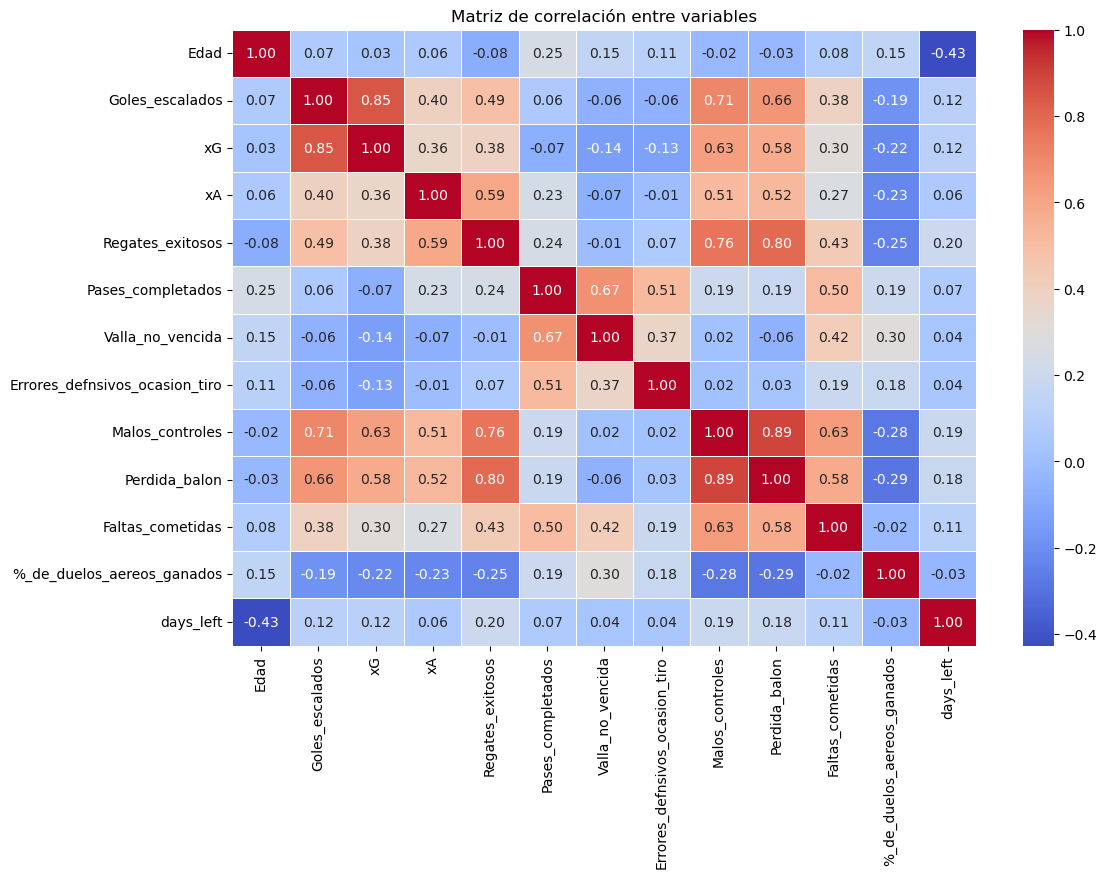

In [62]:
import seaborn as sns
variables = [
    "Edad",
    "Goles_escalados",
    "xG",
    "xA",
    "Regates_exitosos",
    "Pases_completados",
    "Valla_no_vencida",
    "Errores_defnsivos_ocasion_tiro",
    "Malos_controles",
    "Perdida_balon",
    "Faltas_cometidas",
    "%_de_duelos_aereos_ganados",
    "days_left"
]
corr = df_modelo[variables].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables")
plt.show()